Song popularity prediction based on audio features (for now).

In [81]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, r2_score
import graphviz

from datetime import date

%matplotlib inline
sns.set() # Setting seaborn as default style even if use only matplotlib

In [82]:
# constants
dataset_filename = 'Spotify_Dataset_V3_local.csv'
audio_features_col_names = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Valence']

In [83]:
spotify_filepath = os.path.join(os.getcwd(),'data', dataset_filename)
print(spotify_filepath)

spotify_data = pd.read_csv(spotify_filepath, delimiter=";")
spotify_data.head()

/Users/neo/Documents/1-app-ml/aml-code/AML-spotify/data/Spotify_Dataset_V3_local.csv


,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 1,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
2,2,WHERE SHE GOES,Bad Bunny,29/05/2023,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Artist 1,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 1,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...


## data cleaning:
- Assume that 'Song URL' column is not needed
- all values are non-null, no need to remove rows
- should change "Date" column type to datetime
- sort dates via chronological order
- could rename columns (standard variable names)
- Scale the audio features
    - All features [0, 1]
    - Loudness : Log base 10 (of the absolute value) then divde by 60.

*TODO:*
- ~~verify all years full except 2023?~~
    --> total, use 2023

- **for different values (in the audio features) for the same song id:**
    - average
        - currently just taking the first one

In [84]:
spotify_data.columns

Index(['Rank', 'Title', 'Artists', 'Date', 'Danceability', 'Energy',
       'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
       'Valence', '# of Artist', 'Artist (Ind.)', '# of Nationality',
       'Nationality', 'Continent', 'Points (Total)',
       'Points (Ind for each Artist/Nat)', 'id', 'Song URL'],
      dtype='object')

In [85]:
# Assume that 'Song URL' column is not needed
spotify_data.drop(['Song URL'], axis=1, inplace=True, errors='ignore')

# Rename columns
spotify_data = spotify_data.rename(columns={
    "# of Artist": "Num_of_artist", "Artist (Ind.)": "Artist_ind", "# of Nationality": "Num_of_nationality", 
    "Points (Total)": "Points_total", "Points (Ind for each Artist/Nat)": "Points_ind", "Song URL": "Song_URL"
})

In [86]:
# make "Date" column datetime type
spotify_data["Date"] = pd.to_datetime(spotify_data["Date"], dayfirst=True)
spotify_data.info()
# spotify_data.loc[0]["Date"]

# reverse dates
spotify_data = spotify_data.sort_values(by="Date")
# spotify_data.head()

# Keep in mind, ranks are also reversed now...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651936 entries, 0 to 651935
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Rank                651936 non-null  int64         
 1   Title               651936 non-null  object        
 2   Artists             651936 non-null  object        
 3   Date                651936 non-null  datetime64[ns]
 4   Danceability        651936 non-null  float64       
 5   Energy              651936 non-null  float64       
 6   Loudness            651936 non-null  float64       
 7   Speechiness         651936 non-null  float64       
 8   Acousticness        651936 non-null  float64       
 9   Instrumentalness    651936 non-null  float64       
 10  Valence             651936 non-null  float64       
 11  Num_of_artist       651936 non-null  object        
 12  Artist_ind          651936 non-null  object        
 13  Num_of_nationality  651936 no

In [87]:
spotify_data.describe()

,Rank,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Points_total,Points_ind
count,651936.000000,651936,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000,651936.000000
mean,100.407782,2020-03-26 22:03:35.226034688,0.697730,0.652049,-5295.645217,0.109946,0.230694,0.007647,0.523134,100.592218,72.391141
min,1.000000,2017-01-01 00:00:00,0.073000,0.005000,-34475.000000,0.022000,0.000000,0.000000,0.026000,1.000000,0.200000
25%,51.000000,2018-08-23 00:00:00,0.617000,0.549000,-6825.000000,0.045000,0.048000,0.000000,0.356000,51.000000,28.000000
50%,100.000000,2020-03-16 00:00:00,0.719000,0.671000,-5206.000000,0.068000,0.152000,0.000000,0.521000,101.000000,60.000000
75%,150.000000,2021-11-16 00:00:00,0.793000,0.771000,-3885.000000,0.136000,0.349000,0.000000,0.696000,150.000000,104.000000
max,200.000000,2023-05-29 00:00:00,0.985000,0.996000,1509.000000,0.966000,0.994000,0.956000,0.982000,200.000000,200.000000
std,57.406664,NaN,0.133186,0.155684,2785.261321,0.096841,0.230710,0.054724,0.223926,57.406664,54.227892


In [ ]:
# Scale the audio features.
# spotify_data['Loudness'] = spotify_data['Loudness'].apply(lambda x: np.log10(np.abs(x)) / 60)
spotify_data['Loudness']=(spotify_data['Loudness']-spotify_data['Loudness'].mean())/spotify_data['Loudness'].std()
spotify_data.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Num_of_artist,Artist_ind,Num_of_nationality,Nationality,Continent,Points_total,Points_ind,id
651935,200,Ni**as In Paris,"JAY-Z, Kanye West",2017-01-01,0.757,0.882,-0.329951,0.248,0.076,0.0,0.684,Artist 2,Kanye West,Nationality 2,United States,Anglo-America,1,1.0,2KpCpk6HjXXLb7nnXoXA5O
651770,62,Sexual,"NEIKED, Dyo",2017-01-01,0.803,0.569,-0.784846,0.074,0.062,0.0,0.809,Artist 1,NEIKED,Nationality 1,Sweden,Europe,139,70.0,3AsAuGTaDQzavZZThyYlop
651769,61,"How Far I'll Go - From ""Moa""",Alessia Cara,2017-01-01,0.314,0.555,-1.577949,0.370,0.157,0.0,0.159,Artist 1,Alessia Cara,Nationality 1,Canada,Anglo-America,140,140.0,5hYTyyh2odQKphUbMqc5gN
651768,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,-0.933126,0.117,0.057,0.0,0.392,Artist 2,Rihanna,Nationality 2,Barbados,Anglo-America,141,70.0,11KJSRSgaDxqydKYiD2Jew
651767,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,-0.933126,0.117,0.057,0.0,0.392,Artist 1,Drake,Nationality 1,Canada,Anglo-America,141,70.0,11KJSRSgaDxqydKYiD2Jew


## Prepare for classification
Ideas:
* first split into "popular" vs "unpopular"
* then try "hit", "high", "mid", "low"
* then see whether other features such as cumulative days charting, release date, genre etc. can be used as well...?

In [89]:
# want one row per song.
dropped_artist_split = spotify_data.drop_duplicates(subset=['Title', 'Artists', 'Date'], keep="last") 
# TODO: should really keep the first listed artist.

grouped_by_title = dropped_artist_split.groupby(["Title", "Artists"])
grouped_by_title.head()

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Num_of_artist,Artist_ind,Num_of_nationality,Nationality,Continent,Points_total,Points_ind,id
651769,61,"How Far I'll Go - From ""Moa""",Alessia Cara,2017-01-01,0.314,0.555,-1.577949,0.370,0.157,0.0,0.159,Artist 1,Alessia Cara,Nationality 1,Canada,Anglo-America,140,140.0,5hYTyyh2odQKphUbMqc5gN
651767,60,Too Good,"Drake, Rihanna",2017-01-01,0.804,0.648,-0.933126,0.117,0.057,0.0,0.392,Artist 1,Drake,Nationality 1,Canada,Anglo-America,141,70.0,11KJSRSgaDxqydKYiD2Jew
651766,59,Panda,Desiigner,2017-01-01,0.576,0.766,0.094426,0.449,0.028,0.0,0.236,Artist 1,Desiigner,Nationality 1,United States,Anglo-America,142,142.0,5OOkp4U9P9oL23maHFHL1h
651764,58,Perfect Strangers,"Jos Blue, JP Cooper",2017-01-01,0.739,0.833,0.069652,0.046,0.350,0.0,0.699,Artist 1,Jos Blue,Nationality 1,United States,Anglo-America,143,72.0,5bZtRlMBU76vHuDOb1GM5u
651762,57,La Bicicleta,"Carlos Vives, Shakira",2017-01-01,0.736,0.964,1.098281,0.129,0.198,0.0,0.953,Artist 1,Carlos Vives,Nationality 1,Colombia,Latin-America,144,72.0,0sXvAOmXgjR2QUqLK1MltU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,85,Bye,Peso Pluma,2023-05-29,0.782,0.812,-0.505159,0.047,0.567,0.0,0.700,Artist 1,Peso Pluma,Nationality 1,Mexico,Latin-America,116,116.0,6n2P81rPk2RTzwnNNgFOdb
57,37,Dance The Night (From Barbie The Album),Dua Lipa,2023-05-29,0.671,0.845,1.867354,0.048,0.021,0.0,0.775,Artist 1,Dua Lipa,Nationality 1,United Kingdom,Europe,164,164.0,1vYXt7VSjH9JIM5oRRo7vA
52,33,Hits Different,Taylor Swift,2023-05-29,0.672,0.782,-0.464229,0.042,0.148,0.0,0.239,Artist 1,Taylor Swift,Nationality 1,United States,Anglo-America,168,168.0,3xYJScVfxByb61dYHTwiby
284,194,Car's Outside,James Arthur,2023-05-29,0.338,0.562,-0.709090,0.029,0.039,0.0,0.259,Artist 1,James Arthur,Nationality 1,United Kingdom,Europe,7,7.0,0otRX6Z89qKkHkQ9OqJpKt


In [90]:
summed_points = grouped_by_title["Points_total"].sum()

In [92]:
# add on the total points to the right
grouped_df = grouped_by_title.first()

In [93]:
one_row_one_song = grouped_df.merge(summed_points.rename("Points_sum"), left_index=True, right_index=True)
one_row_one_song.drop(['Num_of_nationality', "Nationality", "Continent", "Points_total", "Points_ind", "Num_of_artist", "Artist_ind"], axis=1, inplace=True, errors='ignore')
one_row_one_song

,,Rank,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,id,Points_sum
Title,Artists,,,,,,,,,,,
'98 Braves,Morgan Wallen,72,2023-03-03,0.488,0.670,-0.198545,0.027,0.097,0.0,0.484,3oZ6dlSfCE9gZ55MGPJctc,287
!,Trippie Redd,56,2019-08-09,0.725,0.543,-0.396731,0.084,0.030,0.0,0.693,5a1ofLoPiAn5xxf5UE6472,194
#PROUDCATOWNERREMIX,"XXXTENTACION, Rico Nasty",189,2019-08-23,0.783,0.522,-0.367290,0.390,0.029,0.0,0.235,5dkZ2DrcPJrqwlRQe6Q35e,12
$$$,XXXTENTACION,67,2018-03-16,0.774,0.507,-0.626871,0.065,0.064,0.0,0.508,65u1dHQyQyE4y4aN2eDmMF,1018
$€ Freestyle,Sfera Ebbasta,76,2020-11-20,0.813,0.670,-1.240458,0.335,0.200,0.0,0.380,2j9wr1cxfYcMJoANfmoJA9,125
...,...,...,...,...,...,...,...,...,...,...,...,...
Î©. VIVRE UN PEU,Damso,166,2021-04-29,0.416,0.528,-1.846146,0.291,0.178,0.0,0.203,5UNFWkGaEJgQFqoJxZWMzm,35
ÎŸ. OG,Damso,84,2021-04-29,0.576,0.446,-1.758183,0.044,0.773,0.4,0.060,63ALxy05IGeKrfOjvGG7lO,117
İmdat,cakal,153,2022-04-18,0.786,0.748,-0.848035,0.162,0.267,0.0,0.562,123hB20IVD2yw1NMIgrqb3,1161


In [94]:
one_row_one_song.describe()

,Rank,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Points_sum
count,7801.000000,7801,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000
mean,112.810281,2020-01-14 04:33:22.820151552,0.674761,0.635774,-0.227644,0.131297,0.236030,0.014046,0.487988,6048.995257
min,1.000000,2017-01-01 00:00:00,0.073000,0.005000,-10.508529,0.022000,0.000000,0.000000,0.026000,1.000000
25%,58.000000,2018-06-29 00:00:00,0.582000,0.530000,-0.802438,0.045000,0.041000,0.000000,0.312000,90.000000
50%,120.000000,2020-01-24 00:00:00,0.692000,0.652000,-0.197468,0.078000,0.141000,0.000000,0.485000,588.000000
75%,172.000000,2021-07-23 00:00:00,0.785000,0.761000,0.363341,0.187000,0.355000,0.000000,0.662000,3994.000000
max,200.000000,2023-05-28 00:00:00,0.985000,0.996000,2.410905,0.966000,0.994000,0.956000,0.982000,244737.000000
std,62.625322,NaN,0.148632,0.172027,1.139103,0.120088,0.249934,0.083675,0.226476,15416.891904


In [1]:
# sort by points sum
one_row_one_song.sort_values(by="Points_sum", ascending=False, inplace=True)

# create popularity column and top half is "popular", bottom half is "unpopular"
one_row_one_song["Popularity"] = "n/a"
l = len(one_row_one_song.index) // 2 
one_row_one_song.iloc[:l, -1] = 'popular'
one_row_one_song.iloc[l:, -1] = 'unpopular'

# create binary popularity column and top half is "popular", bottom half is "unpopular"
one_row_one_song["Binary_popularity"] = -2
# l = len(one_row_one_song.index) // 2 
# one_row_one_song.iloc[:l, -1] = 1
# one_row_one_song.iloc[l:, -1] = 0
# one_row_one_song

# one_row_one_song["Binary_popularity"] = [ 1 if i>=one_row_one_song["Points_sum"].mean() else 0 for i in one_row_one_song.Points_sum ]
# one_row_one_song["Binary_popularity"] = [ 1 if i>=1500 else 0 for i in one_row_one_song.Points_sum ]

q = len(one_row_one_song.index) // 4
one_row_one_song.iloc[:q, -1] = 0
one_row_one_song.iloc[q:(q*2), -1] = 1
one_row_one_song.iloc[(q*2):(q*3), -1] = 2
one_row_one_song.iloc[(q*3):, -1] = 3
one_row_one_song["Binary_popularity"].value_counts()

NameError: name 'one_row_one_song' is not defined

## Naive Bayes

In [ ]:
# only features and labels...
nb_df = one_row_one_song.copy(deep=True)

# Student needs to provide code similar to below
X = nb_df.drop(['Date', 'Rank', 'id', 'Points_sum', 'Popularity', 'Binary_popularity'], axis=1)
X=(X-X.mean())/X.std()
X

,,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence
Title,Artists,,,,,,,
Believer,Imagine Dragons,0.701321,0.879084,0.483831,-0.194000,-0.736314,-0.167868,0.971459
Shape of You,Ed Sheeran,1.010811,0.094324,0.837473,-0.427162,1.380243,-0.167868,1.956110
Blinding Lights,The Weeknd,-1.088335,0.931401,0.556324,-0.568725,-0.940367,-0.167868,-0.631359
Someone You Loved,Lewis Capaldi,-1.169072,-1.341494,0.050761,-0.826869,2.060422,-0.167868,-0.185396
Perfect,Ed Sheeran,-0.509725,-1.091534,-0.148754,-0.901814,-0.292197,-0.167868,-1.412899
...,...,...,...,...,...,...,...,...
What I Need (feat. Kehlani),Hayley Kiyoko,-0.280971,0.913962,0.540249,-0.635343,-0.728312,-0.167868,-0.326691
What They Say,Zara Larsson,-1.801507,-0.277710,-0.698443,-0.651997,-0.908359,-0.167868,-1.050830
Din Din Din (Participação especial de MC Pupio e MC Doguinha),LUDMILLA,1.306844,-0.080066,-0.000300,0.821923,-0.088143,-0.167868,1.761829


In [ ]:
# Student needs to provide code similar to below
y = nb_df['Binary_popularity']
y

Title                                                          Artists                     
Believer                                                       Imagine Dragons                 0
Shape of You                                                   Ed Sheeran                      0
Blinding Lights                                                The Weeknd                      0
Someone You Loved                                              Lewis Capaldi                   0
Perfect                                                        Ed Sheeran                      0
                                                                                              ..
What I Need (feat. Kehlani)                                    Hayley Kiyoko                   3
What They Say                                                  Zara Larsson                    3
Din Din Din (Participação especial de MC Pupio e MC Doguinha)  LUDMILLA                        3
Quem Pegou, Pegou - Ao Vivo        

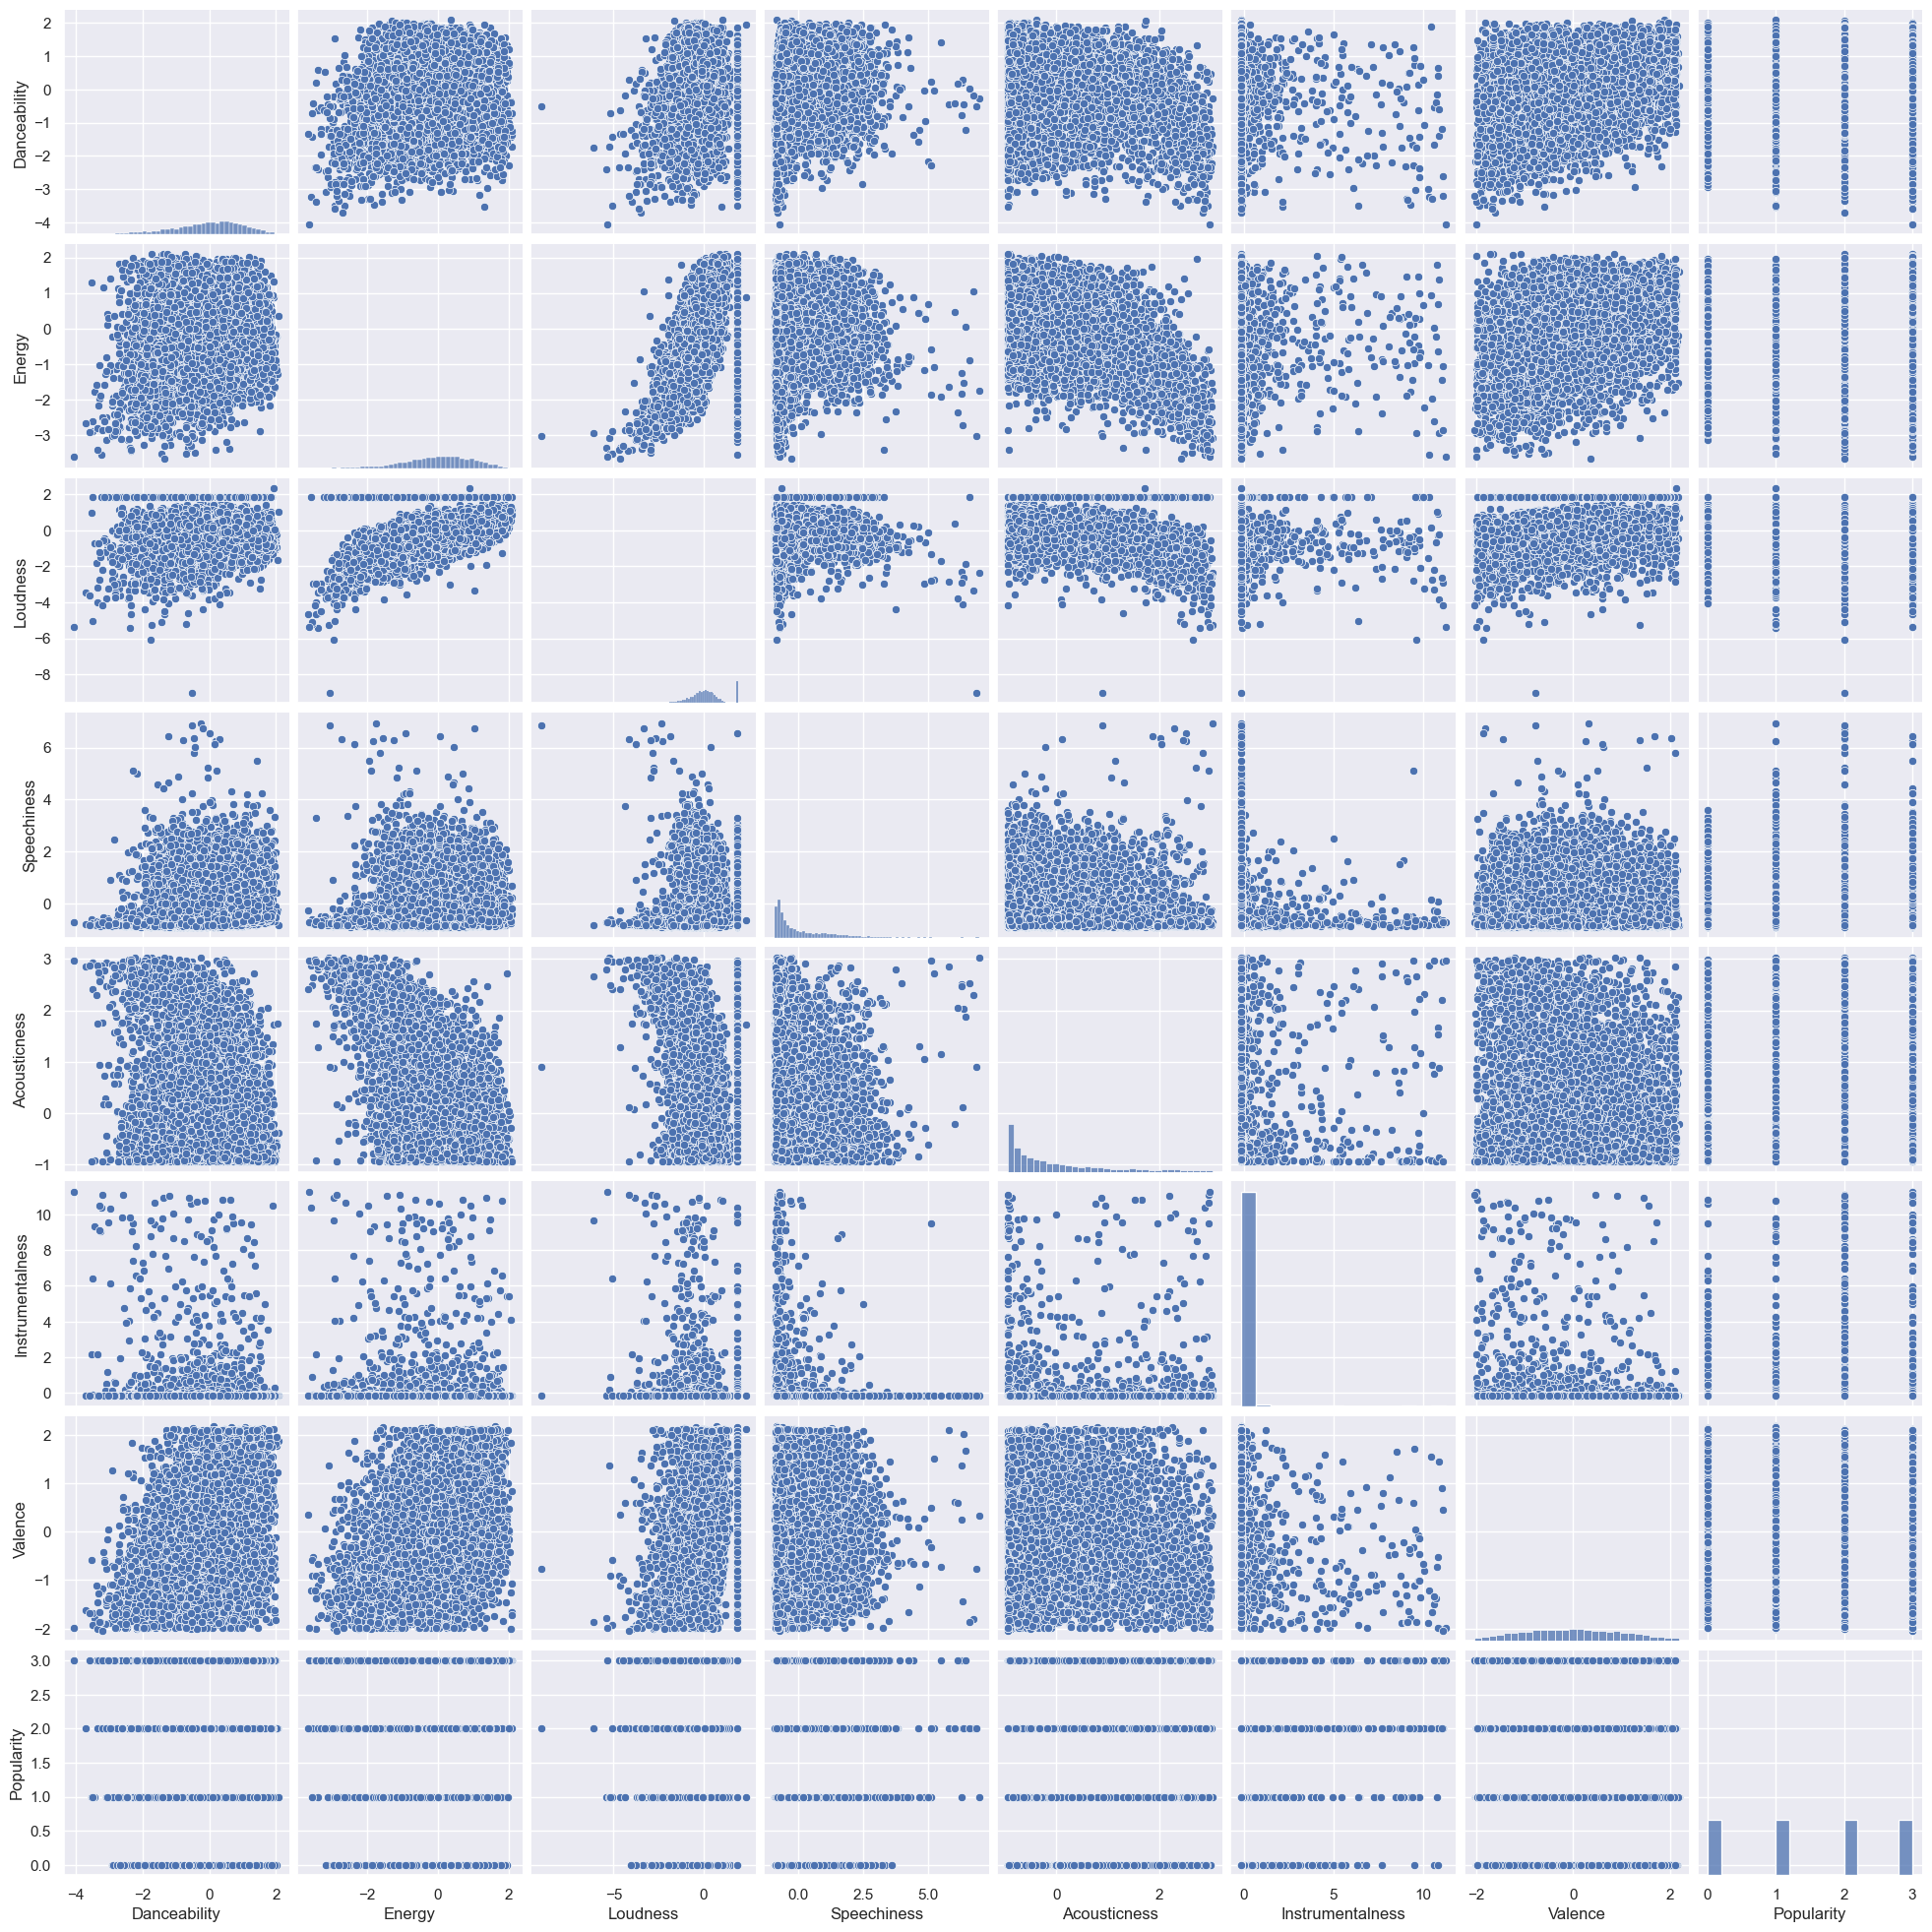

In [ ]:
data_to_model = X.assign(Popularity=y)
sns.pairplot(data_to_model)

In [ ]:
# use Gaussian, not Multinomial?
gnb = GaussianNB()
gnb.fit(X=X, y=y)

GaussianNB()

Training set accuracy check: 53%.

Model application is fine, either it's the wrong model or the features aren't indicative enough.

In [ ]:
ca = gnb.score(X,y)
print('Training set accuracy: {:.2f}%'.format(ca*100))

Training set accuracy: 28.19%


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=8, random_state=0)

In [ ]:
gnb2 = GaussianNB()
gnb2.fit(X=x_train, y=y_train)

GaussianNB()

In [ ]:
ca = gnb.score(x_test,y_test)
print('Test set accuracy: {:.2f}%'.format(ca*100))

Test set accuracy: 12.50%


## Logistic Regression

In [ ]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(x_train, y_train)
print('Classification accuracy on training set: {:.2f}%'.format(lr.score(x_train, y_train)*100))
print('Classification accuracy on test set: {:.2f}%'.format(lr.score(x_test, y_test)*100))

Classification accuracy on training set: 29.83%
Classification accuracy on test set: 25.00%


# Decision Trees

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1000)
dt.fit(x_train.astype(float), y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=1000)

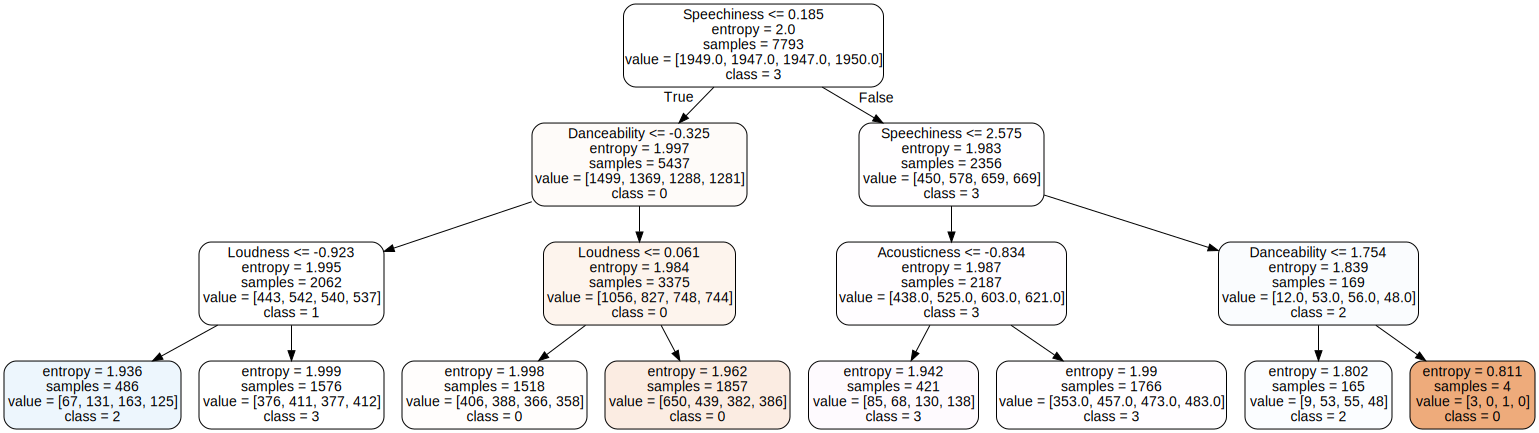

In [ ]:
dot_data = export_graphviz(dt, out_file=None, 
    feature_names=x_train.columns,  
    class_names=['0', '1', '2', '3'],  
    filled=True, rounded=True,  
    special_characters=False)
graph = graphviz.Source(dot_data)
graph

In [ ]:
column_names = x_train.columns
for i, column in enumerate(column_names):
    if dt.feature_importances_[i] > 0:
        print('Importance of feature {}:, {:.3f}'.format(column, dt.feature_importances_[i]))

Importance of feature Danceability:, 0.308
Importance of feature Loudness:, 0.229
Importance of feature Speechiness:, 0.385
Importance of feature Acousticness:, 0.078


In [ ]:
prediction_train = dt.predict(X=x_train)
prediction_test = dt.predict(X=x_test)
print('Classification accuracy on training set: {:.2f}'.format(accuracy_score(y_train,prediction_train)*100))
print('Classification accuracy on test set: {:.2f}'.format(accuracy_score(y_test,prediction_test)*100))

Classification accuracy on training set: 29.64
Classification accuracy on test set: 12.50


## Adding more data

In [ ]:
one_row_one_song_copy = one_row_one_song.copy(deep=True)
excel_data_filepath = os.path.join(os.getcwd(),'data', 'S_Spotify_Dataset_Songs.csv')
print(excel_data_filepath)

excel_data = pd.read_csv(excel_data_filepath, delimiter=",")
excel_data

/Users/neo/Documents/1-app-ml/aml-code/AML-spotify/data/S_Spotify_Dataset_Songs.csv


,Column1,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Published_date,Hot_date,Total_Popularity
0,778,White Christmas,"Bing Crosby, Ken Darby Singers, John Scott Tro...",0.317,0.158,-16485.0,0.038,0.673,0.353,0.247,1942-01-01,2017-11-26,20909
1,4866,It's Beginning To Look Like Christmas,Bing Crosby,0.473,0.212,-15018.0,0.050,0.770,0.000,0.576,1945-01-01,2018-12-24,462
2,4867,Mele Kalikimaka (Merry Christmas),"Bing Crosby, The Andrews Sisters",0.500,0.224,-12431.0,0.094,0.646,0.000,0.620,1945-01-01,2018-12-24,311
3,803,God Rest Ye Merry Gentlemen,Bing Crosby,0.466,0.213,-12009.0,0.045,0.984,0.000,0.693,1945-01-01,2021-12-24,102
4,2028,God Rest Ye Merry Gentlemen,Bing Crosby,0.450,0.202,-9169.0,0.037,0.983,0.009,0.721,1945-01-01,2021-12-24,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,64,Karma (feat. Ice Spice),"Taylor Swift, Ice Spice",0.615,0.616,-6523.0,0.062,0.062,0.000,0.073,2023-05-26,2023-05-26,646
8688,84,Bye,Peso Pluma,0.782,0.812,-6613.0,0.047,0.567,0.000,0.700,2023-05-26,2023-05-26,368
8689,213,War Bout It (feat. 21 Savage),"Lil Durk, 21 Savage",0.732,0.600,-9057.0,0.241,0.004,0.000,0.436,2023-05-26,2023-05-26,123
8690,222,Pelle Coat,Lil Durk,0.747,0.565,-8859.0,0.096,0.004,0.000,0.395,2023-05-26,2023-05-26,29


In [ ]:
# excel_data needs one row per song
excel_data

,Column1,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Published_date,Hot_date,Total_Popularity
0,778,White Christmas,"Bing Crosby, Ken Darby Singers, John Scott Tro...",0.317,0.158,-16485.0,0.038,0.673,0.353,0.247,1942-01-01,2017-11-26,20909
1,4866,It's Beginning To Look Like Christmas,Bing Crosby,0.473,0.212,-15018.0,0.050,0.770,0.000,0.576,1945-01-01,2018-12-24,462
2,4867,Mele Kalikimaka (Merry Christmas),"Bing Crosby, The Andrews Sisters",0.500,0.224,-12431.0,0.094,0.646,0.000,0.620,1945-01-01,2018-12-24,311
3,803,God Rest Ye Merry Gentlemen,Bing Crosby,0.466,0.213,-12009.0,0.045,0.984,0.000,0.693,1945-01-01,2021-12-24,102
4,2028,God Rest Ye Merry Gentlemen,Bing Crosby,0.450,0.202,-9169.0,0.037,0.983,0.009,0.721,1945-01-01,2021-12-24,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,64,Karma (feat. Ice Spice),"Taylor Swift, Ice Spice",0.615,0.616,-6523.0,0.062,0.062,0.000,0.073,2023-05-26,2023-05-26,646
8688,84,Bye,Peso Pluma,0.782,0.812,-6613.0,0.047,0.567,0.000,0.700,2023-05-26,2023-05-26,368
8689,213,War Bout It (feat. 21 Savage),"Lil Durk, 21 Savage",0.732,0.600,-9057.0,0.241,0.004,0.000,0.436,2023-05-26,2023-05-26,123
8690,222,Pelle Coat,Lil Durk,0.747,0.565,-8859.0,0.096,0.004,0.000,0.395,2023-05-26,2023-05-26,29


In [ ]:
one_row_one_song_copy = one_row_one_song_copy.reset_index()
one_row_one_song_copy

,Title,Artists,Rank,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,id,Points_sum,Popularity,Binary_popularity
0,Believer,Imagine Dragons,165,2017-02-02,0.779,0.787,0.323488,0.108,0.052,0.0,0.708,0CcQNd8CINkwQfe1RDtGV6,244737,n/a,1
1,Shape of You,Ed Sheeran,1,2017-01-06,0.825,0.652,0.726323,0.080,0.581,0.0,0.931,7qiZfU4dY1lWllzX7mPBI3,227794,n/a,1
2,Blinding Lights,The Weeknd,8,2019-11-29,0.513,0.796,0.406066,0.063,0.001,0.0,0.345,0sf12qNH5qcw8qpgymFOqD,220508,n/a,1
3,Someone You Loved,Lewis Capaldi,198,2019-01-07,0.501,0.405,-0.169822,0.032,0.751,0.0,0.446,2TIlqbIneP0ZY1O0EzYLlc,220157,n/a,1
4,Perfect,Ed Sheeran,10,2017-03-03,0.599,0.448,-0.397090,0.023,0.163,0.0,0.168,0tgVpDi06FyKpA1z0VMD4v,200148,n/a,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7796,Be My Mistake,The 1975,200,2018-11-30,0.572,0.155,-3.302742,0.034,0.835,0.0,0.095,0AG2l0IboWNSwjUkMr2Aq7,1,n/a,0
7797,"Please Shut Up (feat. A$AP Rocky, KEY! & Gucci...",A$AP Mob,200,2017-08-25,0.859,0.424,-0.340722,0.270,0.102,0.0,0.293,3LyNsopPP3hXf8bZBE7cDk,1,n/a,0
7798,Control,Zoe Wees,200,2020-06-18,0.599,0.465,1.867347,0.031,0.643,0.0,0.068,50Td3qilgs8BLtv8mHyT1t,1,n/a,0
7799,Aïcha,Ninho,200,2021-12-03,0.843,0.622,-0.487925,0.136,0.324,0.0,0.442,3u2NGFCIe5Ynxv8djbpVP8,1,n/a,0


In [ ]:
# pd.concat([df1, df4], axis=1)
spotify_plus = pd.merge(one_row_one_song_copy, excel_data, how="inner", on=["Title", "Artists"])
spotify_plus

,Title,Artists,Rank,Date,Danceability_x,Energy_x,Loudness_x,Speechiness_x,Acousticness_x,Instrumentalness_x,...,Danceability_y,Energy_y,Loudness_y,Speechiness_y,Acousticness_y,Instrumentalness_y,Valence_y,Published_date,Hot_date,Total_Popularity
0,Believer,Imagine Dragons,165,2017-02-02,0.779,0.787,0.323488,0.108,0.052,0.0,...,0.776,0.780,-4374.00,0.128,0.062,0.0,0.666,2017-06-23,2017-02-02,244737
1,Believer,Imagine Dragons,165,2017-02-02,0.779,0.787,0.323488,0.108,0.052,0.0,...,0.784,0.780,-4275.00,0.102,0.049,0.0,0.722,2017-06-23,2017-02-02,244737
2,Believer,Imagine Dragons,165,2017-02-02,0.779,0.787,0.323488,0.108,0.052,0.0,...,0.762,0.787,-4311.00,0.127,0.054,0.0,0.691,2017-06-23,2017-02-02,244737
3,Believer,Imagine Dragons,165,2017-02-02,0.779,0.787,0.323488,0.108,0.052,0.0,...,0.772,0.780,-4288.00,0.108,0.051,0.0,0.719,2017-06-23,2017-02-02,244737
4,Believer,Imagine Dragons,165,2017-02-02,0.779,0.787,0.323488,0.108,0.052,0.0,...,0.779,0.787,-4305.00,0.108,0.052,0.0,0.708,2017-06-23,2017-02-02,244737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,Be My Mistake,The 1975,200,2018-11-30,0.572,0.155,-3.302742,0.034,0.835,0.0,...,0.572,0.155,-14405.00,0.034,0.835,0.0,0.095,2018-11-30,2018-11-30,1
8688,"Please Shut Up (feat. A$AP Rocky, KEY! & Gucci...",A$AP Mob,200,2017-08-25,0.859,0.424,-0.340722,0.270,0.102,0.0,...,0.859,0.424,-6155.00,0.270,0.102,0.0,0.293,2017-08-25,2017-08-25,1
8689,Control,Zoe Wees,200,2020-06-18,0.599,0.465,1.867347,0.031,0.643,0.0,...,0.599,0.465,-4.95,0.031,0.643,0.0,0.068,2020-03-13,2020-06-18,1
8690,Aïcha,Ninho,200,2021-12-03,0.843,0.622,-0.487925,0.136,0.324,0.0,...,0.843,0.622,-6565.00,0.136,0.324,0.0,0.442,2021-12-03,2021-12-03,1
